# Modelo de Riqueza
En este modelo se analiza una economía basada en agentes muy simple, extraída de la econofísica y que presenta un enfoque de mecánica estadística para la distribución de la riqueza [ [Dragulescu2002](https://arxiv.org/abs/cond-mat/0211175) ]. 

## Reglas
Las reglas de nuestro modelo son:
* Hay algunos agentes.
* Todos los agentes comienzan con 1 unidad de dinero.
* En cada paso del modelo, un agente entrega 1 unidad de dinero (si la tiene) a otro agente.

A pesar de su simplicidad, este modelo produce resultados que a menudo son inesperados para quienes no están familiarizados con él. Para nuestros propósitos, también demuestra fácilmente las funciones principales de Mesa.

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar a los integrantes de nuestro sistema usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [76]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from multiprocessing import Pool, Process, Lock
import numpy as np
import pandas as pd

# For a jupyter notebook add the following line:
%matplotlib inline
# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

In [77]:
class MoneyAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.wealth = 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def move(self):
        possibleCells = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False)
        new_position = self.random.choice(possibleCells)
        self.model.grid.move_agent(self, new_position)

In [78]:
def computeGini(model):
    agents_wealth = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agents_wealth)
    N = len(model.schedule.agents)
    acum = 0
    for i, xi in enumerate(x):
        acum += (N - i)*xi
    
    B = acum / (N*sum(x))
    return (1 + (1/N) - 2*B)

In [79]:
class MoneyModel(Model):
    def __init__(self, num_agents, width, height):
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)
        self.datacollector = DataCollector(
            model_reporters={"Gini": computeGini},
            agent_reporters={"Wealth": "wealth"})
        
        for i in range(num_agents):
            agent = MoneyAgent(i, self)
            self.schedule.add(agent)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

(array([5.030e+03, 2.484e+03, 1.186e+03, 6.450e+02, 3.350e+02, 1.750e+02,
        7.700e+01, 3.400e+01, 1.900e+01, 9.000e+00, 5.000e+00, 1.000e+00]),
 array([ 0.        ,  0.91666667,  1.83333333,  2.75      ,  3.66666667,
         4.58333333,  5.5       ,  6.41666667,  7.33333333,  8.25      ,
         9.16666667, 10.08333333, 11.        ]),
 <BarContainer object of 12 artists>)

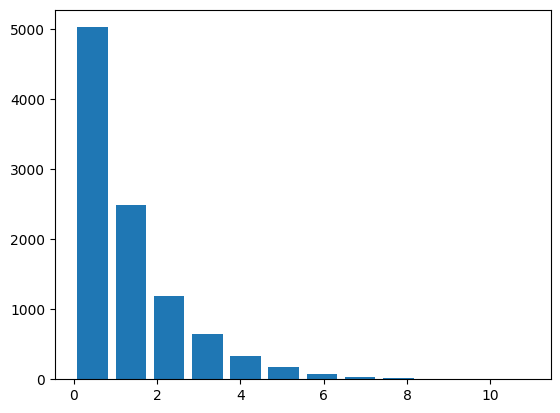

In [97]:
NUM_AGENTS = 10000
GRID_WITH = 100
GRID_HEIGHT = 100
STEPS = 100

model = MoneyModel(NUM_AGENTS, GRID_WITH, GRID_HEIGHT)
for i in range(STEPS):
    model.step()

agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth, bins=max(agent_wealth)+1, rwidth=0.8)

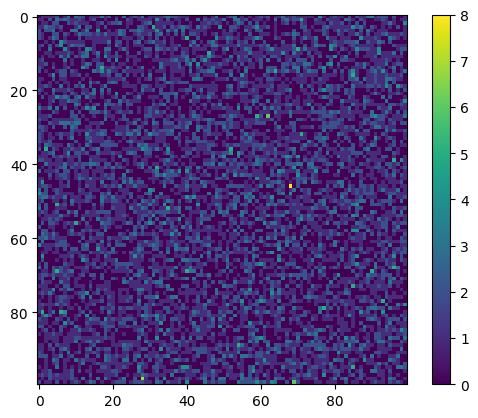

In [98]:
agent_counts = np.zeros((model.grid.width, model.grid.height))

for cell in model.grid.coord_iter():
    cell_content, (x, y) = cell
    agent_counts[x][y] = len(cell_content)

plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()


In [99]:
def runSym(id):
    model = MoneyModel(NUM_AGENTS, GRID_WITH, GRID_HEIGHT)
    for j in range(STEPS):
        model.step()
    wealth = [a.wealth for a in model.schedule.agents]
    return wealth
    

(array([4.96258e+05, 2.53522e+05, 1.26139e+05, 6.23860e+04, 3.11170e+04,
        1.54600e+04, 7.71400e+03, 3.73100e+03, 1.87600e+03, 9.05000e+02,
        4.58000e+02, 2.34000e+02, 1.10000e+02, 4.90000e+01, 1.80000e+01,
        1.40000e+01, 7.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([ 0.        ,  0.94736842,  1.89473684,  2.84210526,  3.78947368,
         4.73684211,  5.68421053,  6.63157895,  7.57894737,  8.52631579,
         9.47368421, 10.42105263, 11.36842105, 12.31578947, 13.26315789,
        14.21052632, 15.15789474, 16.10526316, 17.05263158, 18.        ]),
 <BarContainer object of 19 artists>)

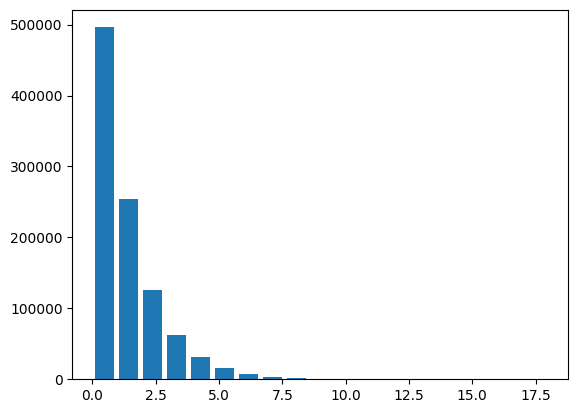

In [101]:
pool = Pool(processes=16)
wealths = pool.map(runSym, range(100))

#wait for all processes to finish
pool.close()

all_wealth = []
for wealth in wealths:
    all_wealth.extend(wealth)

plt.hist(all_wealth, bins=max(all_wealth) + 1, rwidth=0.8)